<a href="https://colab.research.google.com/github/awenroberts/QM2-Project/blob/main/FINAL2_asylum_seekers_receiving_support_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_excel(
    "/content/Copy support-local-authority-datasets-sep-2025.xlsx",
    sheet_name="Data_Asy_D11",
    header=1,
    engine="openpyxl"
)
df.head()

,Date (as at…),Quarter,Year-Quarter,Support Type,UK Region / Nation,Local Authority,LAD Code,Accommodation Type,People
0,2014-03-31,Q1,2014 Q1,Section 4,N/A - Section 4 (pre-2018),N/A - Section 4 (pre-2018),N/A - Section 4 (pre-2018),Dispersal Accommodation,4854
1,2014-03-31,Q1,2014 Q1,Section 95,East Midlands,Amber Valley,E07000032,Subsistence Only,1
2,2014-03-31,Q1,2014 Q1,Section 95,East Midlands,Bassetlaw,E07000171,Subsistence Only,4
3,2014-03-31,Q1,2014 Q1,Section 95,East Midlands,Blaby,E07000129,Subsistence Only,1
4,2014-03-31,Q1,2014 Q1,Section 95,East Midlands,Broxtowe,E07000172,Dispersal Accommodation,7


##Cleaning the dataset

1. check types and change if necessary
2. rename columns
3. clean the dataset - drop rows which have wither 'NaN' or 'N/A' as a value in the lad_code column. this filters out any national level data or missing values.
4. standardise 'accomodation_type' column:

**accomodation_map** is a dictionary which acts as a lookup table:
- "Subsistence Only", "Subsistence only", and "N/A - Section 98 (pre-2023)" are all mapped to the single category "Subsistence Only".
- 'Contingency Accommodation' and 'Other Accommodation' are all grouped under "Contingency Accommodation"
a new column accomodation_type_clean is made, which takes values from the original accomodation_type column and puts it in accomodation_type_clean column according to the map (if there is a match)


In [ ]:
df.head()

,Date (as at…),Quarter,Year-Quarter,Support Type,UK Region / Nation,Local Authority,LAD Code,Accommodation Type,People
0,2014-03-31,Q1,2014 Q1,Section 4,N/A - Section 4 (pre-2018),N/A - Section 4 (pre-2018),N/A - Section 4 (pre-2018),Dispersal Accommodation,4854
1,2014-03-31,Q1,2014 Q1,Section 95,East Midlands,Amber Valley,E07000032,Subsistence Only,1
2,2014-03-31,Q1,2014 Q1,Section 95,East Midlands,Bassetlaw,E07000171,Subsistence Only,4
3,2014-03-31,Q1,2014 Q1,Section 95,East Midlands,Blaby,E07000129,Subsistence Only,1
4,2014-03-31,Q1,2014 Q1,Section 95,East Midlands,Broxtowe,E07000172,Dispersal Accommodation,7


In [ ]:
#check the data types
df.dtypes

,0
Date (as at…),datetime64[ns]
Quarter,object
Year-Quarter,object
Support Type,object
UK Region / Nation,object
Local Authority,object
LAD Code,object
Accommodation Type,object
People,int64


In [ ]:
#change the data types accordingly so we can work with the data usign pandas
df['Quarter']=df['Quarter'].astype('category')
df['Local Authority']=df['Local Authority'].astype('category')
df['UK Region / Nation']=df['UK Region / Nation'].astype('category')
df['LAD Code']=df['LAD Code'].astype('string')
df['Accommodation Type']=df['Accommodation Type'].astype('category')
df['People']=df['People'].astype('int64')

#rename the columns to make things easier later
df = df.rename(columns={
    "Date (as at…)": "date",
    "Quarter": "quarter",
    "Year-Quarter": "year_quarter",
    "Support Type": "support_type",
    "UK Region / Nation": "region",
    "Local Authority": "local_authority",
    "LAD Code": "lad_code",
    "Accommodation Type": "accommodation_type",
    "People": "people"
})

#convert the date column
df["date"] = pd.to_datetime(df["date"], errors="coerce")
# Ensure date is datetime
df["date"] = pd.to_datetime(df["date"])
#check it worked
df["date"].min(), df["date"].max()
#create proper quarterly time variable
df["year_quarter"] = df["date"].dt.to_period("Q")

In [ ]:
df["date"] = pd.PeriodIndex(df["date"], freq="Q").to_timestamp()

# Sort
df = df.sort_values("date")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26135 entries, 0 to 26134
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                26135 non-null  datetime64[ns]
 1   quarter             26135 non-null  category      
 2   year_quarter        26135 non-null  period[Q-DEC] 
 3   support_type        26135 non-null  object        
 4   region              26135 non-null  category      
 5   local_authority     26135 non-null  category      
 6   lad_code            26043 non-null  string        
 7   accommodation_type  26135 non-null  category      
 8   people              26135 non-null  int64         
dtypes: category(4), datetime64[ns](1), int64(1), object(1), period[Q-DEC](1), string(1)
memory usage: 1.3+ MB


In [ ]:
#cleaning
#get rid of the national level data and null values and put it into a new dataframe
df = df[~df["lad_code"].str.startswith("N/A", na=False)].copy()
df_unclean = df[df["lad_code"].isna() | df["lad_code"].str.startswith("N/A", na=False)]
df_unclean

,date,quarter,year_quarter,support_type,region,local_authority,lad_code,accommodation_type,people
231,2014-01-01,Q1,2014Q1,Section 95,Unknown,Unknown,<NA>,Subsistence Only,25
230,2014-01-01,Q1,2014Q1,Section 95,Unknown,Unknown,<NA>,Dispersal Accommodation,133
532,2014-04-01,Q2,2014Q2,Section 95,Unknown,Unknown,<NA>,Subsistence Only,26
531,2014-04-01,Q2,2014Q2,Section 95,Unknown,Unknown,<NA>,Dispersal Accommodation,127
854,2014-07-01,Q3,2014Q3,Section 95,Unknown,Unknown,<NA>,Subsistence Only,29
...,...,...,...,...,...,...,...,...,...
16102,2023-01-01,Q1,2023Q1,Section 95,Unknown,Unknown,<NA>,Dispersal Accommodation,200
16103,2023-01-01,Q1,2023Q1,Section 95,Unknown,Unknown,<NA>,Subsistence Only,139
15652,2023-01-01,Q1,2023Q1,Section 4,Unknown,Unknown,<NA>,Dispersal Accommodation,26
17177,2023-04-01,Q2,2023Q2,Section 95,Unknown,Unknown,<NA>,Subsistence Only,165


In [ ]:
df_no_support_type = df.drop(columns=['support_type'])
df_no_support_type

,date,quarter,year_quarter,region,local_authority,lad_code,accommodation_type,people
198,2014-01-01,Q1,2014Q1,South East,Milton Keynes,E06000042,Subsistence Only,9
197,2014-01-01,Q1,2014Q1,South East,Mid Sussex,E07000228,Subsistence Only,5
196,2014-01-01,Q1,2014Q1,South East,Medway,E06000035,Subsistence Only,3
195,2014-01-01,Q1,2014Q1,South East,Maidstone,E07000110,Subsistence Only,3
194,2014-01-01,Q1,2014Q1,South East,Hastings,E07000062,Subsistence Only,1
...,...,...,...,...,...,...,...,...
25336,2025-07-01,Q3,2025Q3,East of England,Stevenage,E07000243,Contingency Accommodation - Hotel,342
25335,2025-07-01,Q3,2025Q3,East of England,St Albans,E07000240,Dispersal Accommodation,3
25334,2025-07-01,Q3,2025Q3,East of England,St Albans,E07000240,Contingency Accommodation - Hotel,60
25332,2025-07-01,Q3,2025Q3,East of England,South Norfolk,E07000149,Dispersal Accommodation,3


In [ ]:
#create a map which harmonsises the dataset to include 4 accomodation types of interest
#map with 'other' merged with contingency
accommodation_map = {
    # Subsistence-only variants
    "Subsistence Only": "Subsistence Only",
    "Subsistence only": "Subsistence Only",
    "N/A - Section 98 (pre-2023)": "Subsistence Only",

    # Initial accommodation
    "Initial Accommodation": "Initial Accommodation",

    # Dispersal (long-term, normalised)
    "Dispersal Accommodation": "Dispersal Accommodation",

    # Contingency + alternatives to hotels
    "Contingency Accommodation - Hotel": "Contingency Accommodation",
    "Contingency Accommodation - Other": "Contingency Accommodation",
    "Other Accommodation": "Contingency Accommodation",
}
df["accommodation_type_clean"] = df["accommodation_type"].map(accommodation_map)


In [ ]:
df["accommodation_type_clean"].value_counts()

,count
accommodation_type_clean,
Dispersal Accommodation,12718
Subsistence Only,9282
Contingency Accommodation,3819
Initial Accommodation,260


In [ ]:
#check how many LAs are in the dataframe in 2025 (period of interest)
df_2025 = df[(df["date"]  >= "2025-01-01") & (df["date"] <= "2025-12-31")]
df_2025.columns
df_2025["lad_code"].nunique()

345

In [ ]:
# Group by the specified columns and sum the 'people' column
#df_final = df_2025.groupby([
  #  'date', 'quarter', 'year_quarter', 'region', 'local_authority', 'lad_code', 'accommodation_type_clean'
#], observed=False)['people'].sum().reset_index()

#df_final

##Explore the data and generate summary statistics

In [ ]:
# Filter period of interest
df_plot = df[(df["date"] >= "2019-01-01") & (df["date"] <= "2025-12-31")]

In [ ]:
#create a dataframe called 'national' which contains only the variables of interest: number of people given support by accomodation type nationally
national = (
    df_plot
    .groupby(["date", "accommodation_type_clean"])["people"]
    .sum()
    .reset_index()
)

In [ ]:
#make a new dataframe called 'pivot' from the national dataframe, using the pivot function
pivot = national.pivot(
    #make 'date' the index of the dataframe
    index="date",
    #values from accomodation_type_clean are now the columns of the dataframe
    columns="accommodation_type_clean",
    #specifies values to fill in the dataframe (no. of asylum seekers)
    values="people"
)

# Sort chronologically (important!)
pivot = pivot.sort_index()
pivot.head()

accommodation_type_clean,Contingency Accommodation,Dispersal Accommodation,Initial Accommodation,Subsistence Only
date,,,,
2019-01-01,NaN,46505.0,NaN,3046.0
2019-04-01,NaN,46075.0,NaN,3021.0
2019-07-01,NaN,45071.0,NaN,2942.0
2019-10-01,NaN,44506.0,NaN,2847.0
2020-01-01,NaN,45465.0,NaN,2856.0


<Figure size 1400x800 with 0 Axes>

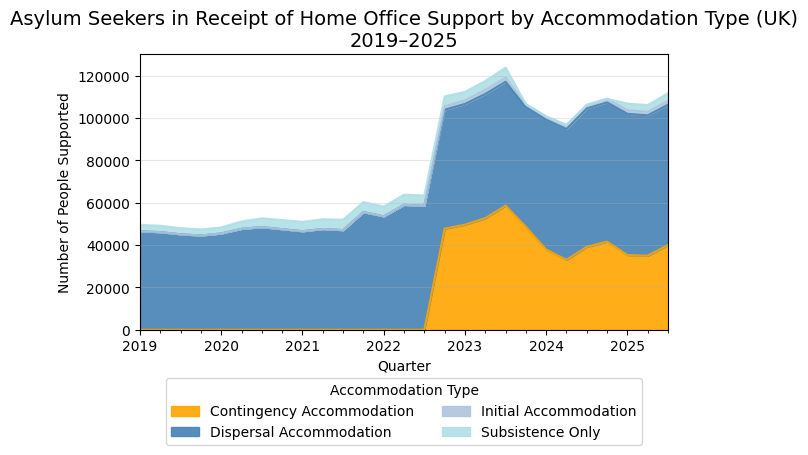

In [ ]:
#plot the 'pivot' (national data) in a stacked graph

plt.figure(figsize=(14,8))

# Define the custom colors in the order of the columns in 'pivot'
custom_colors = ['orange', 'steelblue', 'lightsteelblue', 'powderblue']
pivot.plot.area(stacked=True, alpha=0.9, color=custom_colors)

plt.title(
    "Asylum Seekers in Receipt of Home Office Support by Accommodation Type (UK)\n2019–2025",
    fontsize=14
)
plt.xlabel("Quarter")
plt.ylabel("Number of People Supported")
plt.legend(
    title="Accommodation Type",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2
)

plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

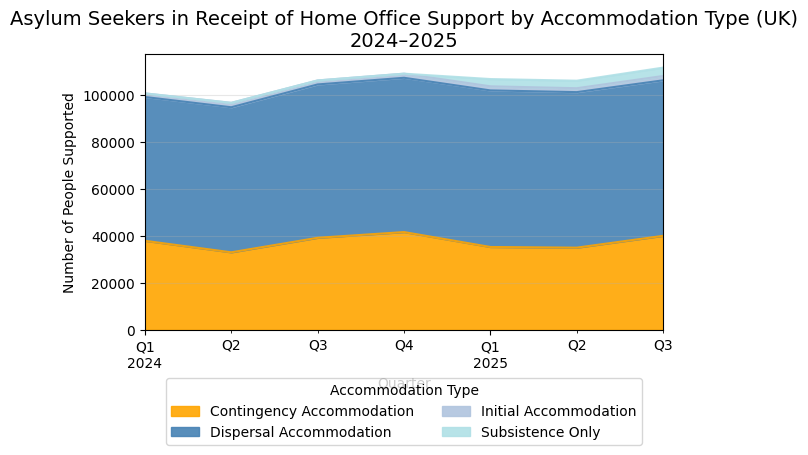

In [ ]:
# Filter to 2024–2025 only
pivot_2425 = pivot.loc["2024-01-01":"2025-12-31"]

custom_colors = ['orange', 'steelblue', 'lightsteelblue', 'powderblue']

plt.figure(figsize=(14,8))
pivot_2425.plot.area(stacked=True, alpha=0.9,color=custom_colors)

plt.title(
    "Asylum Seekers in Receipt of Home Office Support by Accommodation Type (UK)\n2024–2025",
    fontsize=14
)
plt.xlabel("Quarter")
plt.ylabel("Number of People Supported")
plt.legend(
    title="Accommodation Type",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2
)
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

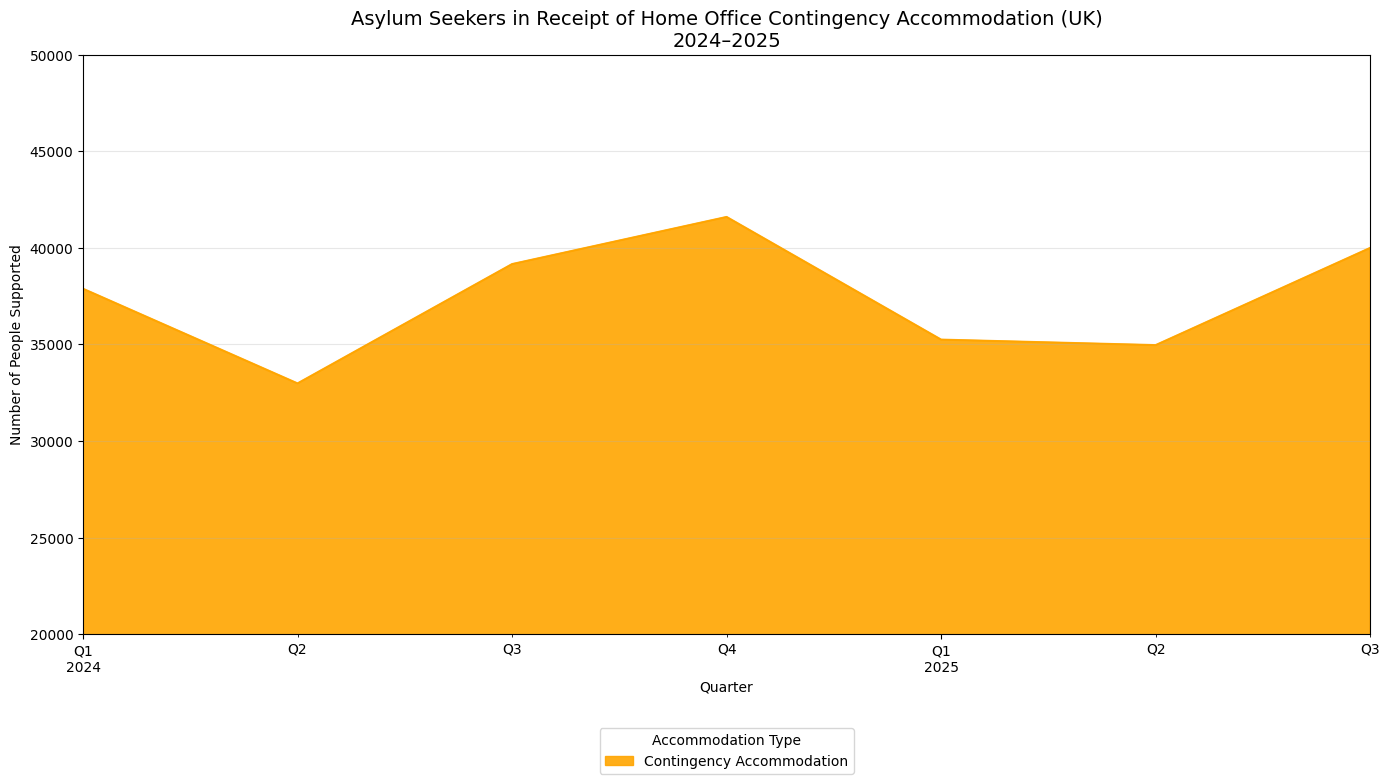

In [ ]:
#plot just contingency trend
custom_colors = ['orange', 'steelblue', 'lightsteelblue', 'powderblue']

pivot_2425_contingency = pivot_2425.loc[:, "Contingency Accommodation"]

plt.figure(figsize=(14,8))
pivot_2425_contingency.plot.area(stacked=True, alpha=0.9,color=custom_colors)

plt.title(
    "Asylum Seekers in Receipt of Home Office Contingency Accommodation (UK)\n2024–2025",
    fontsize=14
)
plt.xlabel("Quarter")
plt.ylabel("Number of People Supported")
plt.legend(
    title="Accommodation Type",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2
)
plt.grid(axis="y", alpha=0.3)

# Set y-axis limit
plt.ylim(20000, 50000)

plt.tight_layout()
plt.show()

In [ ]:
# Convert counts to proportions (row-wise)
pivot_prop = pivot_2425_contingency.div(pivot_2425.sum(axis=1), axis=0) * 100

/tmp/ipython-input-2041065979.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


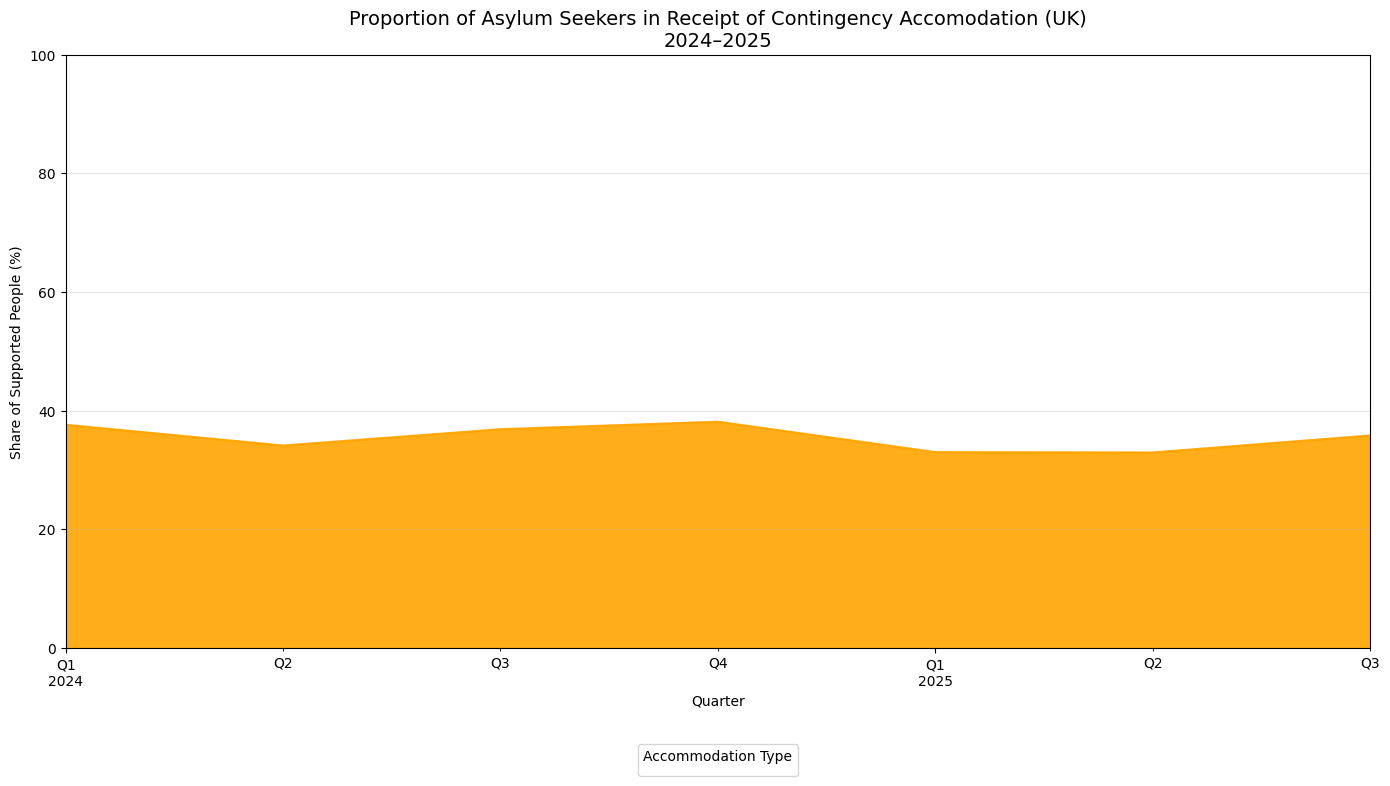

In [ ]:
#plot proportion of asylum seekers in contingency accomodation trendss
plt.figure(figsize=(14,8))
custom_colors = ['orange', 'steelblue', 'lightsteelblue', 'powderblue']
pivot_prop.plot.area(stacked=True, alpha=0.9, color=custom_colors)

plt.title("Proportion of Asylum Seekers in Receipt of Contingency Accomodation (UK)\n2024–2025", fontsize=14)
plt.xlabel("Quarter")
plt.ylabel("Share of Supported People (%)")
plt.legend(
    title="Accommodation Type",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2
)
plt.grid(axis="y", alpha=0.3)

plt.ylim(0, 100)

plt.tight_layout()
plt.show()

##Bring in population data

In [ ]:
import pandas as pd

#import population data for local authorities
xls = pd.ExcelFile("/content/Copy support-local-authority-datasets-sep-2025.xlsx")
print("Available Excel sheets:", xls.sheet_names)


pop_df = pd.read_excel(
    "/content/Copy support-local-authority-datasets-sep-2025.xlsx",
    sheet_name="population_per_LA",
    header=0,
    engine="openpyxl"
)
pop_df.head()

Available Excel sheets: ['Cover_sheet', 'Contents', 'Notes', 'List_of_Fields', 'Asy_D11', 'Data_Asy_D11', 'Data_Asy_D11_2020_2025', 'population_per_LA', 'la_exposure_table', 'la_exposure_table_old', '2025', 'protest_data', 'population for local authoritie']


,lad_code,name,geography,population,Isy
0,E06000047,County Durham,Unitary Authority,538011,True
1,E06000005,Darlington,Unitary Authority,112489,True
2,E06000001,Hartlepool,Unitary Authority,98180,True
3,E06000002,Middlesbrough,Unitary Authority,156161,True
4,E06000057,Northumberland,Unitary Authority,331420,True


In [ ]:
#check number of LAs is correct
pop_df.columns
pop_df["lad_code"].nunique()

354

In [ ]:
#merge population dataframe with asylum support dataframe by lad_code
df_merged = df.merge(
    pop_df[["lad_code", "population"]],
    on="lad_code",
    how="left"
)
df_merged = df_merged[(df_merged["date"]  >= "2025-01-01") & (df_merged["date"] <= "2025-12-31")]

#group people by accomodation_type_clean
df_merged

,date,quarter,year_quarter,support_type,region,local_authority,lad_code,accommodation_type,people,accommodation_type_clean,population
22558,2025-01-01,Q1,2025Q1,Section 95,South East,Oxford,E07000178,Contingency Accommodation - Hotel,190,Contingency Accommodation,166034.0
22559,2025-01-01,Q1,2025Q1,Section 95,South East,Oxford,E07000178,Dispersal Accommodation,27,Dispersal Accommodation,166034.0
22560,2025-01-01,Q1,2025Q1,Section 95,South East,New Forest,E07000091,Subsistence Only,1,Subsistence Only,176116.0
22561,2025-01-01,Q1,2025Q1,Section 95,South East,Mole Valley,E07000210,Subsistence Only,1,Subsistence Only,88709.0
22562,2025-01-01,Q1,2025Q1,Section 95,South East,Milton Keynes,E06000042,Subsistence Only,11,Subsistence Only,305884.0
...,...,...,...,...,...,...,...,...,...,...,...
26074,2025-07-01,Q3,2025Q3,Section 95,East of England,Stevenage,E07000243,Contingency Accommodation - Hotel,342,Contingency Accommodation,91774.0
26075,2025-07-01,Q3,2025Q3,Section 95,East of England,St Albans,E07000240,Dispersal Accommodation,3,Dispersal Accommodation,151012.0
26076,2025-07-01,Q3,2025Q3,Section 95,East of England,St Albans,E07000240,Contingency Accommodation - Hotel,60,Contingency Accommodation,151012.0
26077,2025-07-01,Q3,2025Q3,Section 95,East of England,South Norfolk,E07000149,Dispersal Accommodation,3,Dispersal Accommodation,148448.0


In [ ]:
# Group by the specified columns and sum the 'people' column
df_final = df_merged.groupby([
    'date', 'quarter', 'year_quarter', 'region', 'local_authority', 'lad_code', 'accommodation_type_clean', 'population'
], observed=False)['people'].sum().reset_index()

df_final

In [ ]:
df_merged

#Metric 1 — Contingency accommodation per 1,000 residents
This captures local visibility / pressure, which is what protests respond to.

0.5 = 1 person in contingency per 2,000 residents
2.0 = very high local exposure

In [ ]:
contingency_df = df_merged[
    df_merged["accommodation_type_clean"] == "Contingency Accommodation"
].copy()
contingency_df

In [ ]:
#create a new dataframe (copy) which filters df_merged for rows where the 'accommodation_type_clean' has the value 'Contingency Accomodation'
contingency_df = df_merged[
    df_merged["accommodation_type_clean"] == "Contingency Accommodation"
].copy()

#divide the number of people in contingency accomodation by the population in each LA then *1000
contingency_df["contingency_per_1000"] = (
    contingency_df["people"] / contingency_df["population"]
) * 1000

#sort by lad_code
contingency_df = contingency_df.sort_values("lad_code")
contingency_df


In [ ]:

df_no_support_type = contingency_df.drop(columns=['support_type'])
df_no_support_type

In [ ]:
q3_contingency_per_1000 = contingency_df.query("year_quarter == @pd.Period('2025Q3', freq='Q')")

display(q3_contingency_per_1000[['lad_code', 'local_authority', 'contingency_per_1000']])

In [ ]:
q2_contingency_per_1000 = contingency_df.query("year_quarter == @pd.Period('2025Q2', freq='Q')")

display(q2_contingency_per_1000[['lad_code', 'local_authority', 'contingency_per_1000']])

In [ ]:
q1_contingency_per_1000 = contingency_df.query("year_quarter == @pd.Period('2025Q1', freq='Q')")

display(q1_contingency_per_1000[['lad_code', 'local_authority', 'contingency_per_1000']])

#Metric 2 — Change in contingency accommodation (Q1 → Q3 2025)
This captures local shocks, not national trends.

In [ ]:
#keep only 2025 Q1 and Q3
quarters_to_filter = pd.PeriodIndex(["2025Q1", "2025Q3"], freq="Q")
cont_2025 = contingency_df[
    contingency_df["year_quarter"].isin(quarters_to_filter)
]

#pivot to wide format
cont_wide = cont_2025.pivot_table(
    index="lad_code",
    columns="year_quarter",
    values="people",
    aggfunc="sum"
).reset_index()

#compute the change
cont_wide["delta_contingency_Q1_Q3"] = (
    cont_wide[pd.Period('2025Q3', freq='Q')] - cont_wide[pd.Period('2025Q1', freq='Q')]
)

cont_wide

#Metric 3: share of local asylum population in contingency accomodation

tells us how dominant levels are locally, not nationally.

In [ ]:
#caculate total asylum population per LA-quarter
total_asylum = (
    df
    .groupby(["lad_code", "year_quarter"], as_index=False)
    ["people"]
    .sum()
    .rename(columns={"people": "total_asylum"})
)

total_asylum

In [ ]:
#merge totals into contingency data
contingency_total = contingency_df.merge(
    total_asylum,
    on=["lad_code", "year_quarter"],
    how="left"
)

contingency_total.head()

In [ ]:
print(f"Shape of contingency_total: {contingency_total.shape}")
print(f"Number of null values in 'total_asylum' column: {contingency_total['total_asylum'].isnull().sum()}")

In [ ]:
#compute share
contingency_total["contingency_share"] = (
    contingency_total["people"] / contingency_total["total_asylum"]
)
contingency_total

In [ ]:
#final LA-level exposure table
la_exposure = (
    contingency_total
    .query("year_quarter == @pd.Period('2025Q3', freq='Q')") # Corrected query to use Period object
    [["lad_code", "local_authority", "population", "total_asylum", "contingency_per_1000", "contingency_share"]]
    .merge(
        cont_wide[["lad_code", "delta_contingency_Q1_Q3"]],
        on="lad_code",
        how="left"
    )
)
#round population column to a whole number
la_exposure["population"] = la_exposure["population"].round(0).astype(int)
#round the values in all columns to four decimal points
la_exposure["contingency_share"] = la_exposure["contingency_share"].round(4)
la_exposure["contingency_per_1000"] = la_exposure["contingency_per_1000"].round(4)
la_exposure["delta_contingency_Q1_Q3"] = la_exposure["contingency_share"].round(4)

#check for anny errors, null values or N/A in any column
#la_exposure.info()
#change object types to correct types for quantitative analysis
la_exposure["population"] = la_exposure["population"].astype(int)
la_exposure["total_asylum"] = la_exposure["total_asylum"].astype(int)
la_exposure["contingency_share"] = la_exposure["contingency_share"].astype(int)
la_exposure["contingency_per_1000"] = la_exposure["contingency_per_1000"].astype(int)
la_exposure["delta_contingency_Q1_Q3"] = la_exposure["contingency_share"].astype(int)

la_exposure